In [1]:
%cd C:\\Users\\SahilSrivastava\\Desktop\\finalyear\

C:\Users\SahilSrivastava\Desktop\finalyear


C:\Users\SahilSrivastava\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import os
from glob import glob

excel_files = glob('./HourlyData/*.xlsx')

month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Sort the files based on the year and month extracted from the filenames
def extract_year_month(file_path):
    filename = os.path.basename(file_path)
    parts = filename.split('_')
    year = int(parts[2])
    month_name = parts[3]
    month = month_mapping[month_name]
    return year, month

excel_files = sorted(excel_files, key=extract_year_month)

# Initialize an empty DataFrame to store the combined data
all_data = pd.DataFrame()


# Loop through each file and read the data
# Loop through each file and read the data
for file in excel_files:
    # Read the Excel file, skipping rows and columns with NaN values
    df = pd.read_excel(file, header=0, index_col=0).dropna(axis=0, how='any').dropna(axis=1, how='any')
    # Extract year and month from the filename
    filename = os.path.basename(file)
    parts = filename.split('_')
    year = int(parts[2])
    month_name = parts[3]
    month = month_mapping[month_name]
    # Construct the datetime index using year, month, day, and hour information
    days_in_month = df.index
    hours_in_day = df.columns
    datetime_index = pd.date_range(start=f"{year}-{month:02d}-01 00:00:00", 
                                   periods=len(days_in_month)*len(hours_in_day), freq='h')
    # Reshape the data to have a datetime index and AQI values
    reshaped_data = pd.DataFrame(df.values.flatten(), index=datetime_index, columns=['AQI'])
    # Append to the combined DataFrame
    all_data = pd.concat([all_data, reshaped_data])


# Sort by datetime index
all_data = all_data.sort_index()

# Handle missing values
all_data = all_data.ffill().bfill()

# Display the first few rows of the processed data
print(all_data)

                       AQI
2020-01-01 00:00:00  500.0
2020-01-01 01:00:00  500.0
2020-01-01 02:00:00  500.0
2020-01-01 03:00:00  500.0
2020-01-01 04:00:00  494.0
...                    ...
2023-12-26 19:00:00  155.0
2023-12-26 20:00:00  208.0
2023-12-26 21:00:00  278.0
2023-12-26 22:00:00  312.0
2023-12-26 23:00:00  314.0

[25848 rows x 1 columns]


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Extract features and target from the data
X = all_data.index.values  # Time as the feature
y = all_data['AQI'].values  # AQI as the target

# Convert the datetime index to ordinal values (numeric) for modeling
X = pd.to_datetime(all_data.index).to_series().apply(lambda x: x.toordinal()).values.reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, shuffle=False)

# Print shapes to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (25589, 1), y_train shape: (25589,)
X_test shape: (259, 1), y_test shape: (259,)


In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

# Check for NaN values in X_train and y_train
nan_indices = np.isnan(X_train).any(axis=1) | np.isnan(y_train)

# Remove rows with NaN values
X_train_cleaned = X_train[~nan_indices]
y_train_cleaned = y_train[~nan_indices]

# Define and initialize the Linear Regression model
lr_model = LinearRegression()

# Fit the model
lr_model.fit(X_train_cleaned, y_train_cleaned)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

# Calculate evaluation metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

# Print the evaluation metrics
print(f"Linear Regression MSE: {mse_lr}, R2: {r2_lr},MAE:{mae_lr}")


Linear Regression MSE: 15115.637783254264, R2: -1.3363680920334615,MAE:108.55741329874556


In [5]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_lr = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf}, R2: {r2_rf},MAE:{mae_lr}")


Random Forest MSE: 13941.730411001467, R2: -1.1549215816802736,MAE:104.43909909909908


In [6]:
import xgboost as xgb

# XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_lr = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MSE: {mse_xgb}, R2: {r2_xgb},MAE:{mae_lr}")


XGBoost MSE: 7013.709385599107, R2: -0.08408305691627094,MAE:72.4378409956413


In [7]:
from sklearn.svm import SVR

# Support Vector Machine model
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_svr = svr_model.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
mae_lr = mean_absolute_error(y_test, y_pred_svr)
print(f"SVM MSE: {mse_svr}, R2: {r2_svr},MAE:{mae_lr}")


SVM MSE: 21300.84414556383, R2: -2.292392508254374,MAE:129.125569145197


In [8]:
from sklearn.neighbors import KNeighborsRegressor

# K-Nearest Neighbors model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = knn_model.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
mae_lr = mean_absolute_error(y_test, y_pred_knn)

print(f"KNN MSE: {mse_knn}, R2: {r2_knn},,MAE: {mae_lr}")


KNN MSE: 14294.245405405407, R2: -1.2094085174416707,,MAE: 105.67644787644787


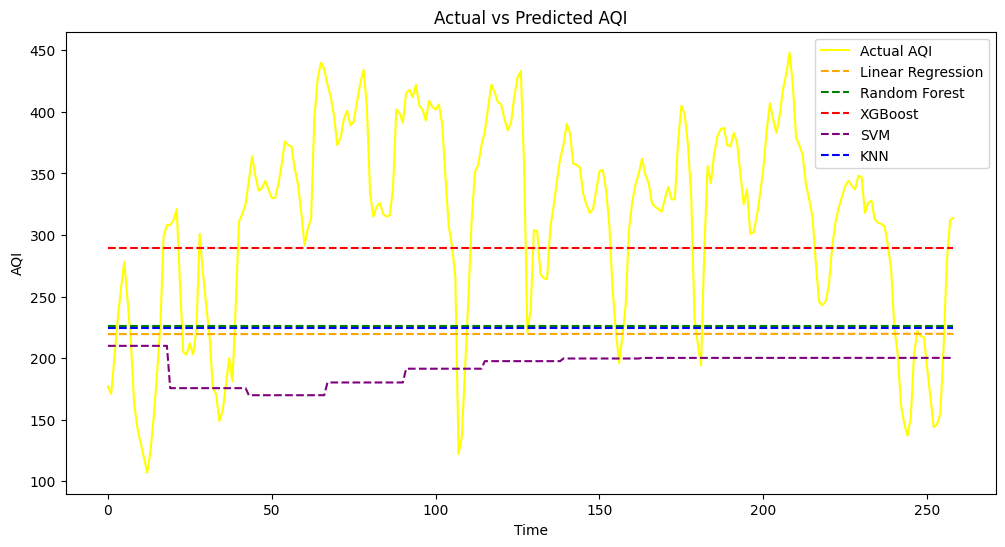

In [9]:
import matplotlib.pyplot as plt

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual AQI', linestyle='-', color='yellow')
plt.plot(y_pred_lr, label='Linear Regression', linestyle='--', color='orange')
plt.plot(y_pred_rf, label='Random Forest', linestyle='--', color='green')
plt.plot(y_pred_xgb, label='XGBoost', linestyle='--', color='red')
plt.plot(y_pred_svr, label='SVM', linestyle='--', color='purple')
plt.plot(y_pred_knn, label='KNN', linestyle='--', color='blue')
plt.legend()
plt.xlabel('Time')
plt.ylabel('AQI')
plt.title('Actual vs Predicted AQI')
plt.show()


Linear Regression MSE: 1288.1268838785152, R2: 0.9088808760402435, MAE: 24.291891666817392


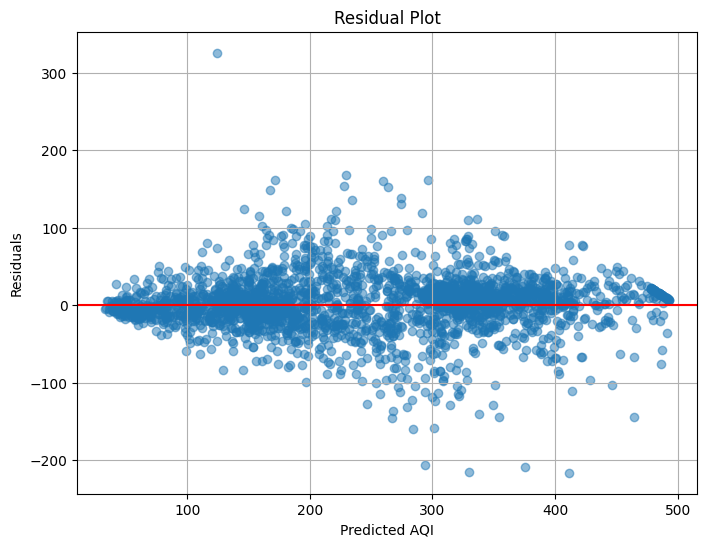

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Extract additional temporal features
all_data['hour'] = all_data.index.hour
all_data['day_of_week'] = all_data.index.dayofweek
all_data['day_of_month'] = all_data.index.day
all_data['month'] = all_data.index.month

# Optionally, you could also create lag features (e.g., previous hour's AQI)
all_data['AQI_lag1'] = all_data['AQI'].shift(1)
all_data = all_data.dropna()  # Drop rows with NaN values resulting from lagging

# Define the features (X) and the target (y)
X = all_data[['hour', 'day_of_week', 'day_of_month', 'month', 'AQI_lag1']]
y = all_data['AQI']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

# Calculate evaluation metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

# Print the evaluation metrics
print(f"Linear Regression MSE: {mse_lr}, R2: {r2_lr}, MAE: {mae_lr}")

# Visualize Residuals
import matplotlib.pyplot as plt

residuals = y_test - y_pred_lr
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lr, residuals, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted AQI')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.show()
